In [771]:
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt

import matplotlib as mpl
import seaborn as sns
import cell2location

# 1. Load datas

In [772]:
# set paths
sp_data_folder = '/home/jsw/BI/Database/Ravi_Cancer_Cell_2022/10XVisium_2/'
results_folder = './results/'

regression_model_output = 'RegressionModelOutput'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'

def read_and_qc(sample_name, path = sp_data_folder, batch = None):
    r'''Reads the data for one 10X spatial experiment into the anndata object
    It also calculates QC metrics
    
    :param sample_name: Name of the sample
    :param path: path to data
    '''
    adata = sc.read_visium(path + str(sample_name) + '/outs/',
                           count_file = 'filtered_feature_bc_matrix.h5', load_images = True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.obs['Batch'] = batch
    adata.var.rename(columns = {'gene_ids': 'ENSEMBL'}, inplace = True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns = 'ENSEMBL', inplace = True)
    
    # Calculate QC metrics
    from scipy.sparse import csr_matrix
    adata.X = adata.X.toarray()
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.X = csr_matrix(adata.X)
    adata.var['MT'] = [gene.startswith('MT-') for gene in adata.var['SYMBOL']]
    adata.obs['MT_frac'] = adata[:, adata.var['MT'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']
    
    # add sample name to obs names
    adata.obs['sapmle'] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs['sample'] + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'
    
    return adata


def select_slide(adata, s, s_col = 'sample'):
    r'''Selets the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    '''
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]
    
    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

In [773]:
# read csv and store the first column as list
import pandas as pd
sample_data = pd.read_csv('../spatial_data.csv')
sample_data['combined_id'] = sample_data['ID'] + '_' + sample_data['Tissue_Type'] + '_ST'

In [774]:
sample_data

ID Tissue_Type  Batch     Region  Age   Tumor Histology Sex  MALDI  \
0   #UKF260           T      5   temporal   81  IDH-WT       GBM   m    1.0   
1   #UKF255           T      5   temporal   81  IDH-WT       GBM   f    NaN   
2   #UKF248           T      1    frontal   44  IDH-WT       GBM   m    NaN   
3   #UKF243           T      1    frontal   55  IDH-WT       GBM   f    NaN   
4   #UKF275           T      6    frontal   80  IDH-WT       GBM   f    1.0   
5   #UKF269           T      6  occipital   51  IDH-WT       GBM   m    NaN   
6   #UKF262           T      5   temporal   59  IDH-WT       GBM   m    1.0   
7   #UKF304           T      9   temporal   81  IDH-WT       GBM   m    NaN   
8   #UKF313           T     10   temporal   57  IDH-WT       GBM   m    NaN   
9   #UKF334           T     10    frontal   73  IDH-WT       GBM   f    NaN   
10  #UKF241           C      1   temporal   19       C    Cortex   m    NaN   

    IMC   combined_id  
0   1.0  #UKF260_T_ST  
1   NaN  #UKF255_T_ST  
2   NaN  #UKF248_T_ST  
3   NaN  #UKF243_T_ST  
4   1.0  #UKF275_T_ST  
5   NaN  #UKF269_T_ST  
6   1.0  #UKF262_T_ST  
7   NaN  #UKF304_T_ST  
8   NaN  #UKF313_T_ST  
9   NaN  #UKF334_T_ST  
10  NaN  #UKF241_C_ST

In [775]:
slides = []
for batch, combined_id in zip(sample_data['Batch'], sample_data['combined_id']):
    slides.append(read_and_qc(combined_id, batch = batch))
    
# Combine anndata objects together
adata = slides[0].concatenate(
    slides[1:],
    # batch_key='batch',
    uns_merge='unique',
    # batch_categories=sample_data['combined_id'],
    index_unique=None
)

# replace the sample names with the new names
spatial_to_sample = pd.read_csv('../spatial_to_sample.csv')
for index, row in spatial_to_sample.iterrows():
    old_key = row['old']
    new_key = row['new']
    if old_key in adata.uns['spatial']:
        adata.uns['spatial'][new_key] = adata.uns['spatial'].pop(old_key)
    

/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jsw/jswenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_m

KeyboardInterrupt: 

/tmp/ipykernel_6435/2849191182.py:52: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
/tmp/ipykernel_6435/2849191182.py:52: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
/tmp/ipykernel_6435/2849191182.py:52: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
/tmp/ipykernel_6435/2849191182.py:52: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
/tmp/ipykernel_6435/2849191182.py:52: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  slide.uns['spatial

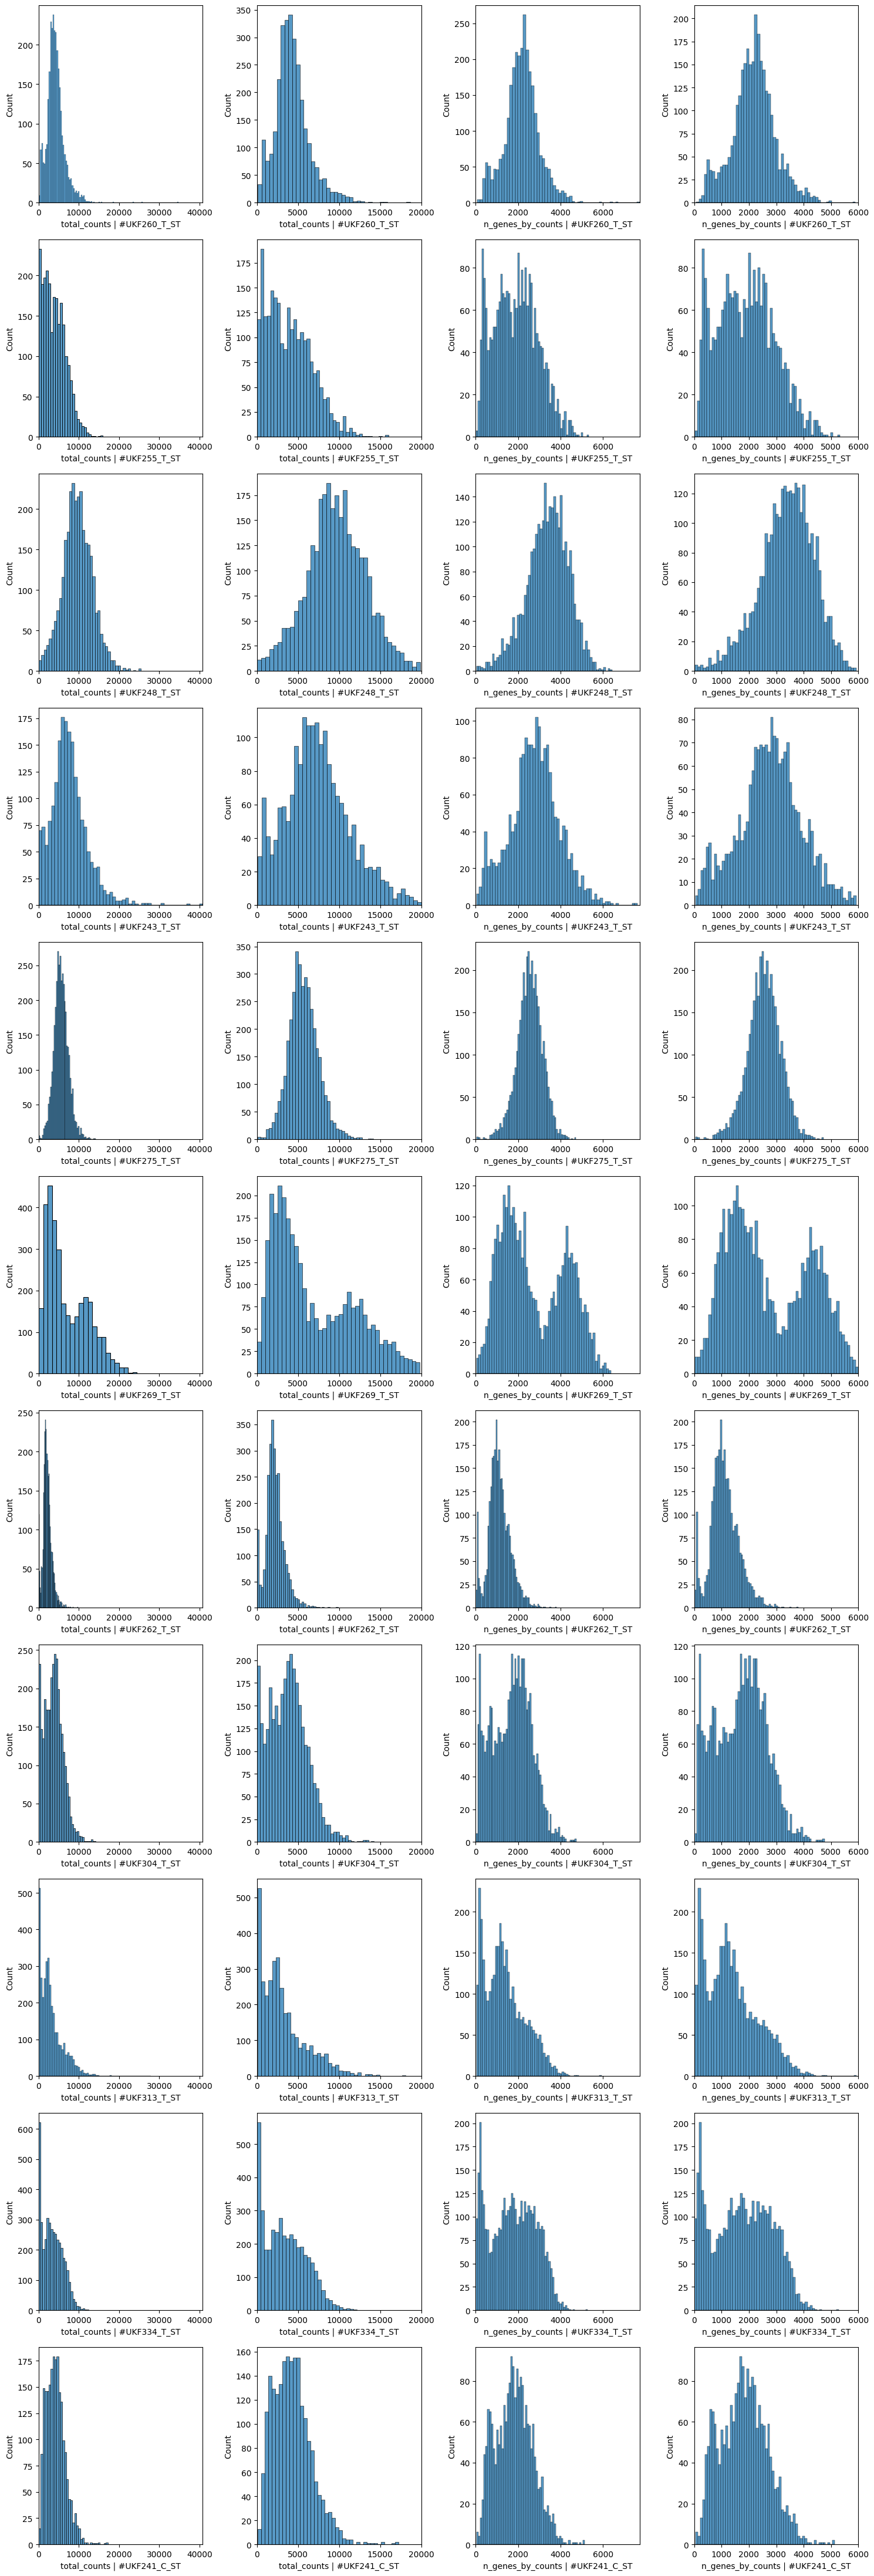

In [ ]:
# PLOT QC FOR EACH SAMPLE
fig, axs = plt.subplots(len(slides), 4, figsize=(15, 4*len(slides)))
for i, s in enumerate(adata.obs['sample'].unique()):
    #fig.suptitle('Covariates for filtering')

    slide = select_slide(adata, s)
    
    sns.histplot(slide.obs['total_counts'],
                 kde=False, ax = axs[i, 0])
    axs[i, 0].set_xlim(0, adata.obs['total_counts'].max())
    axs[i, 0].set_xlabel(f'total_counts | {s}')

    sns.histplot(slide.obs['total_counts']\
                 [slide.obs['total_counts']<20000],
                 kde=False, bins=40, ax = axs[i, 1])
    axs[i, 1].set_xlim(0, 20000)
    axs[i, 1].set_xlabel(f'total_counts | {s}')

    sns.histplot(slide.obs['n_genes_by_counts'],
                 kde=False, bins=60, ax = axs[i, 2])
    axs[i, 2].set_xlim(0, adata.obs['n_genes_by_counts'].max())
    axs[i, 2].set_xlabel(f'n_genes_by_counts | {s}')

    sns.histplot(slide.obs['n_genes_by_counts']\
                 [slide.obs['n_genes_by_counts']<6000],
                 kde=False, bins=60, ax = axs[i, 3])
    axs[i, 3].set_xlim(0, 6000)
    axs[i, 3].set_xlabel(f'n_genes_by_counts | {s}')

plt.tight_layout()

---
# Visualize

In [ ]:
# Select slide
slide = select_slide(adata, '#UKF243_T_ST')

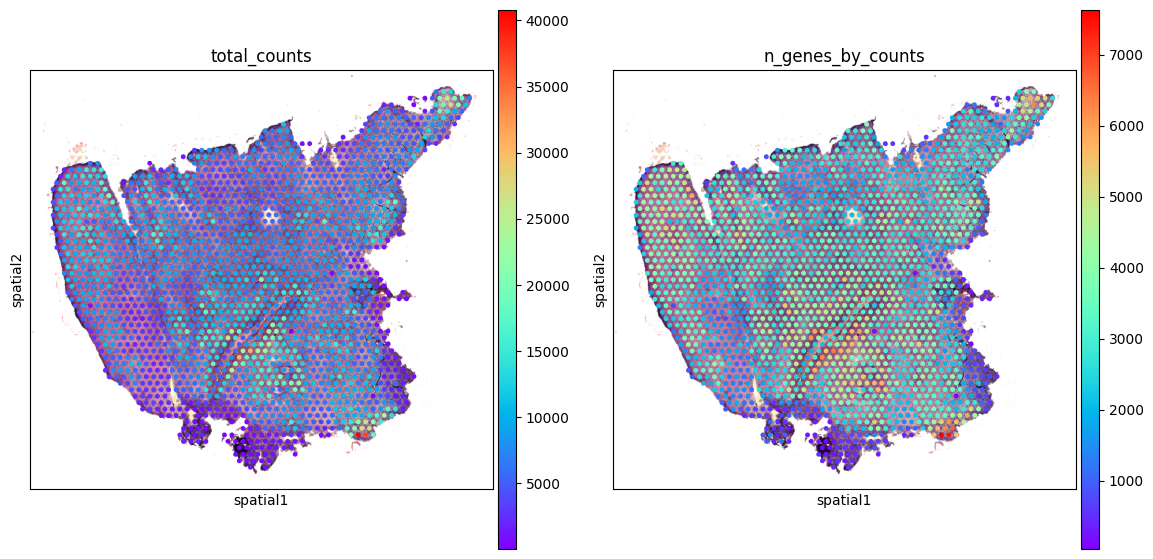

In [ ]:
with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'black'}):
    sc.pl.spatial(
        slide,
        img_key = "hires",
        cmap='rainbow',
        library_id=list(slide.uns['spatial'].keys())[0],
        color=['total_counts', 'n_genes_by_counts'],
        size=1,
        gene_symbols='SYMBOL',
        show=False,
        return_fig=True
    )

In [ ]:
slide.obs

in_tissue  array_row  array_col  \
spot_id                                                            
#UKF243_T_ST_AAACAAGTATCTCCCA-1          1         50        102   
#UKF243_T_ST_AAACATTTCCCGGATT-1          1         61         97   
#UKF243_T_ST_AAACCGGGTAGGTACC-1          1         42         28   
#UKF243_T_ST_AAACCGTTCGTCCAGG-1          1         52         42   
#UKF243_T_ST_AAACCTCATGAAGTTG-1          1         37         19   
...                                    ...        ...        ...   
#UKF243_T_ST_TTGTTAGCAAATTCGA-1          1         22         42   
#UKF243_T_ST_TTGTTCAGTGTGCTAC-1          1         24         64   
#UKF243_T_ST_TTGTTGTGTGTCAAGA-1          1         31         77   
#UKF243_T_ST_TTGTTTCACATCCAGG-1          1         58         42   
#UKF243_T_ST_TTGTTTCCATACAACT-1          1         45         27   

                                       sample  Batch  n_genes_by_counts  \
spot_id                                                                   
#UKF243_T_ST_AAACAAGTATCTCCCA-1  #UKF243_T_ST      1               1385   
#UKF243_T_ST_AAACATTTCCCGGATT-1  #UKF243_T_ST      1               6190   
#UKF243_T_ST_AAACCGGGTAGGTACC-1  #UKF243_T_ST      1               2390   
#UKF243_T_ST_AAACCGTTCGTCCAGG-1  #UKF243_T_ST      1               1064   
#UKF243_T_ST_AAACCTCATGAAGTTG-1  #UKF243_T_ST      1               4300   
...                                       ...    ...                ...   
#UKF243_T_ST_TTGTTAGCAAATTCGA-1  #UKF243_T_ST      1               1163   
#UKF243_T_ST_TTGTTCAGTGTGCTAC-1  #UKF243_T_ST      1               1409   
#UKF243_T_ST_TTGTTGTGTGTCAAGA-1  #UKF243_T_ST      1               3289   
#UKF243_T_ST_TTGTTTCACATCCAGG-1  #UKF243_T_ST      1               1121   
#UKF243_T_ST_TTGTTTCCATACAACT-1  #UKF243_T_ST      1               2937   

                                 log1p_n_genes_by_counts  total_counts  \
spot_id                                                                  
#UKF243_T_ST_AAACAAGTATCTCCCA-1                 7.234177        2710.0   
#UKF243_T_ST_AAACATTTCCCGGATT-1                 8.730852       26763.0   
#UKF243_T_ST_AAACCGGGTAGGTACC-1                 7.779467        5425.0   
#UKF243_T_ST_AAACCGTTCGTCCAGG-1                 6.970730        2044.0   
#UKF243_T_ST_AAACCTCATGAAGTTG-1                 8.366603       13392.0   
...                                                  ...           ...   
#UKF243_T_ST_TTGTTAGCAAATTCGA-1                 7.059618        2147.0   
#UKF243_T_ST_TTGTTCAGTGTGCTAC-1                 7.251345        2815.0   
#UKF243_T_ST_TTGTTGTGTGTCAAGA-1                 8.098643        8102.0   
#UKF243_T_ST_TTGTTTCACATCCAGG-1                 7.022868        2043.0   
#UKF243_T_ST_TTGTTTCCATACAACT-1                 7.985484        7129.0   

                                 log1p_total_counts  \
spot_id                                               
#UKF243_T_ST_AAACAAGTATCTCCCA-1            7.905073   
#UKF243_T_ST_AAACATTTCCCGGATT-1           10.194813   
#UKF243_T_ST_AAACCGGGTAGGTACC-1            8.598957   
#UKF243_T_ST_AAACCGTTCGTCCAGG-1            7.623153   
#UKF243_T_ST_AAACCTCATGAAGTTG-1            9.502487   
...                                             ...   
#UKF243_T_ST_TTGTTAGCAAATTCGA-1            7.672292   
#UKF243_T_ST_TTGTTCAGTGTGCTAC-1            7.943073   
#UKF243_T_ST_TTGTTGTGTGTCAAGA-1            8.999990   
#UKF243_T_ST_TTGTTTCACATCCAGG-1            7.622664   
#UKF243_T_ST_TTGTTTCCATACAACT-1            8.872066   

                                 pct_counts_in_top_50_genes  ...  \
spot_id                                                      ...   
#UKF243_T_ST_AAACAAGTATCTCCCA-1                   27.896679  ...   
#UKF243_T_ST_AAACATTTCCCGGATT-1                   27.635168  ...   
#UKF243_T_ST_AAACCGGGTAGGTACC-1                   31.649770  ...   
#UKF243_T_ST_AAACCGTTCGTCCAGG-1                   31.800391  ...   
#UKF243_T_ST_AAACCTCATGAAGTTG-1                   32.078853  ...   
...              

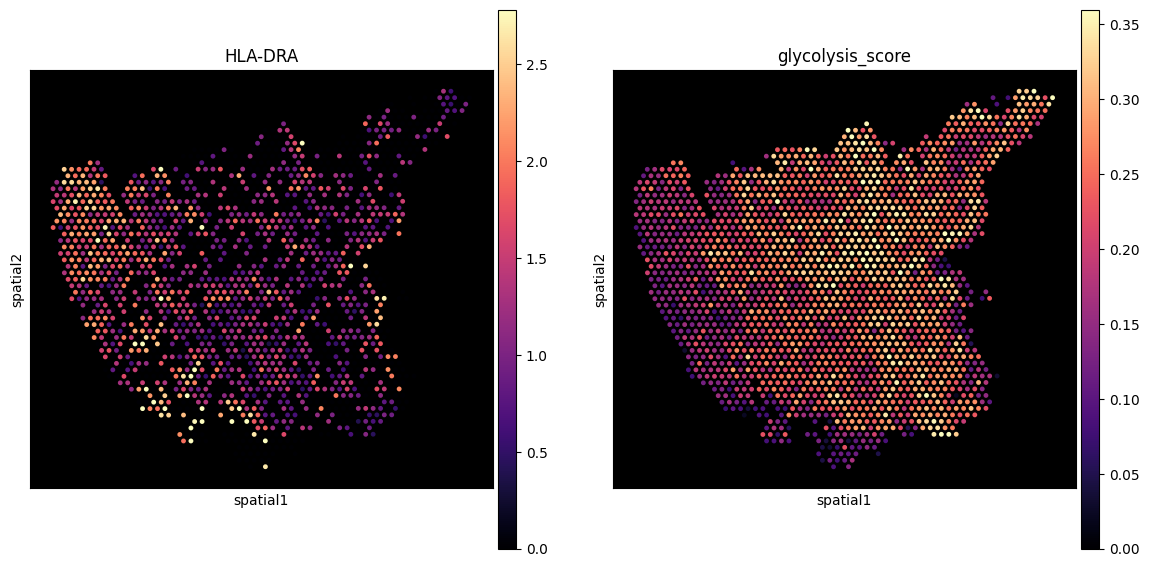

In [ ]:
with mpl.rc_context({'figure.figsize': [6,7],
                     'axes.facecolor': 'black'}):
    sc.pl.spatial(
        slide,
        color=["HLA-DRA", 'glycolysis_score'], #TOP2A
        img_key=None,
        size=1,
        vmin=0,
        cmap='magma',
        vmax='p99.0',
        gene_symbols='SYMBOL'
    )

---
# cell2location

In [ ]:
inf_aver = pd.read_csv('../data/inf_aver.csv', index_col = 0)

In [ ]:
adata.obs

in_tissue  array_row  array_col  \
spot_id                                                            
#UKF260_T_ST_AAACAATCTACTAGCA-1          1          3         43   
#UKF260_T_ST_AAACAGAGCGACTCCT-1          1         14         94   
#UKF260_T_ST_AAACAGCTTTCAGAAG-1          1         43          9   
#UKF260_T_ST_AAACAGGGTCTATATT-1          1         47         13   
#UKF260_T_ST_AAACATGGTGAGAGGA-1          1         62          0   
...                                    ...        ...        ...   
#UKF241_C_ST_TTGTGTTTCCCGAAAG-1          1         51         59   
#UKF241_C_ST_TTGTTAGCAAATTCGA-1          1         22         42   
#UKF241_C_ST_TTGTTCAGTGTGCTAC-1          1         24         64   
#UKF241_C_ST_TTGTTGTGTGTCAAGA-1          1         31         77   
#UKF241_C_ST_TTGTTTCACATCCAGG-1          1         58         42   

                                       sample  Batch  n_genes_by_counts  \
spot_id                                                                   
#UKF260_T_ST_AAACAATCTACTAGCA-1  #UKF260_T_ST      5               2895   
#UKF260_T_ST_AAACAGAGCGACTCCT-1  #UKF260_T_ST      5               1757   
#UKF260_T_ST_AAACAGCTTTCAGAAG-1  #UKF260_T_ST      5               3523   
#UKF260_T_ST_AAACAGGGTCTATATT-1  #UKF260_T_ST      5               2273   
#UKF260_T_ST_AAACATGGTGAGAGGA-1  #UKF260_T_ST      5               1068   
...                                       ...    ...                ...   
#UKF241_C_ST_TTGTGTTTCCCGAAAG-1  #UKF241_C_ST      1               1989   
#UKF241_C_ST_TTGTTAGCAAATTCGA-1  #UKF241_C_ST      1                639   
#UKF241_C_ST_TTGTTCAGTGTGCTAC-1  #UKF241_C_ST      1               1264   
#UKF241_C_ST_TTGTTGTGTGTCAAGA-1  #UKF241_C_ST      1               2279   
#UKF241_C_ST_TTGTTTCACATCCAGG-1  #UKF241_C_ST      1               1223   

                                 log1p_n_genes_by_counts  total_counts  \
spot_id                                                                  
#UKF260_T_ST_AAACAATCTACTAGCA-1                 7.971086        5313.0   
#UKF260_T_ST_AAACAGAGCGACTCCT-1                 7.471932        4043.0   
#UKF260_T_ST_AAACAGCTTTCAGAAG-1                 8.167352        8278.0   
#UKF260_T_ST_AAACAGGGTCTATATT-1                 7.729296        4406.0   
#UKF260_T_ST_AAACATGGTGAGAGGA-1                 6.974479        1977.0   
...                                                  ...           ...   
#UKF241_C_ST_TTGTGTTTCCCGAAAG-1                 7.595890        4782.0   
#UKF241_C_ST_TTGTTAGCAAATTCGA-1                 6.461468        1488.0   
#UKF241_C_ST_TTGTTCAGTGTGCTAC-1                 7.142827        2956.0   
#UKF241_C_ST_TTGTTGTGTGTCAAGA-1                 7.731931        5177.0   
#UKF241_C_ST_TTGTTTCACATCCAGG-1                 7.109879        2520.0   

                                 log1p_total_counts  \
spot_id                                               
#UKF260_T_ST_AAACAATCTACTAGCA-1            8.578100   
#UKF260_T_ST_AAACAGAGCGACTCCT-1            8.304990   
#UKF260_T_ST_AAACAGCTTTCAGAAG-1            9.021478   
#UKF260_T_ST_AAACAGGGTCTATATT-1            8.390949   
#UKF260_T_ST_AAACATGGTGAGAGGA-1            7.589841   
...                                             ...   
#UKF241_C_ST_TTGTGTTTCCCGAAAG-1            8.472823   
#UKF241_C_ST_TTGTTAGCAAATTCGA-1            7.305860   
#UKF241_C_ST_TTGTTCAGTGTGCTAC-1            7.991930   
#UKF241_C_ST_TTGTTGTGTGTCAAGA-1            8.552175   
#UKF241_C_ST_TTGTTTCACATCCAGG-1            7.832411   

                                 pct_counts_in_top_50_genes  \
spot_id                                                       
#UKF260_T_ST_AAACAATCTACTAGCA-1                   16.864295   
#UKF260_T_ST_AAACAGAGCGACTCCT-1                   29.977739   
#UKF260_T_ST_AAACAGCTTTCAGAAG-1                   24.365789   
#UKF260_T_ST_AAACAGGGTCTATATT-1                   25.465275   
#UKF260_T_ST_AAACATGGTGAGAGGA-1                   33.434497   
...                                                 

In [ ]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata.var_names, inf_aver.index)
adata = adata[:, intersect].copy()
inf_aver = inf_aver.loc[intersect].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(
    adata = adata,
    batch_key = 'Batch'
)

In [ ]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata,
    cell_state_df = inf_aver,
    N_cells_per_location = 30,
    detection_alpha = 20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Batch',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   5   │
│         n_cells          │ 33094 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 22425 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Batch'] │     1      │          0          │
│                    │     5      │          1          │
│                    │     6      │          2          │
│                    │     9      │          3          │
│                    │     10     │          4          │
└────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [ ]:
import torch

In [ ]:
torch.cuda.empty_cache()

In [ ]:
mod.train(
    max_epochs = 15000,
    batch_size = 4096,
    train_size = 1,
    
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jsw/jswenv/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jsw/jswenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to impro

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15000` reached.


---

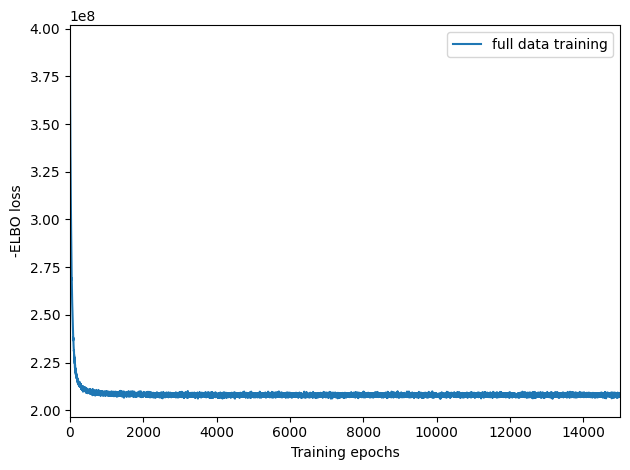

In [ ]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history()
plt.legend(labels=['full data training'])

In [ ]:
# Export the estimated cell abundance (summary of the posterior distribution)
adata = mod.export_posterior(
    adata,
    sample_kwargs = {
        'num_samples': 1000,
        'batch_size': 1000
    }
)

Sampling local variables, batch:   0%|          | 0/34 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

In [ ]:
# save model
mod.save('run_model', overwrite = True)

In [ ]:
# save anndata object with results
adata.write('run_model/sp.h5ad')

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt

import matplotlib as mpl
import seaborn as sns
import cell2location

In [ ]:
import torch
torch.no_grad()

In [ ]:
# load adata
adata = sc.read_h5ad('run_model/sp.h5ad')
# mod = cell2location.models.Cell2location.load('run_model', adata)

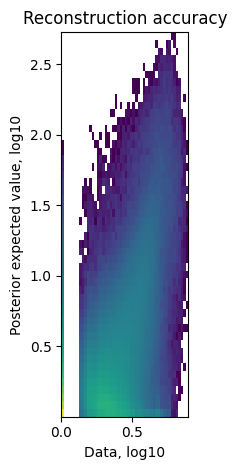

In [ ]:
mod.plot_QC()

In [ ]:
adata.obs[adata.uns['mod']['factor_names']] = adata.obsm['q05_cell_abundance_w_sf']

In [ ]:
adata.obs.rename(columns = {"CD4": "CD4_T"}, inplace = True)
adata.var.set_index('SYMBOL', inplace = True)

In [ ]:
# Normalization
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)

/home/jsw/jswenv/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [ ]:
%matplotlib tk
# %matplotlib inline

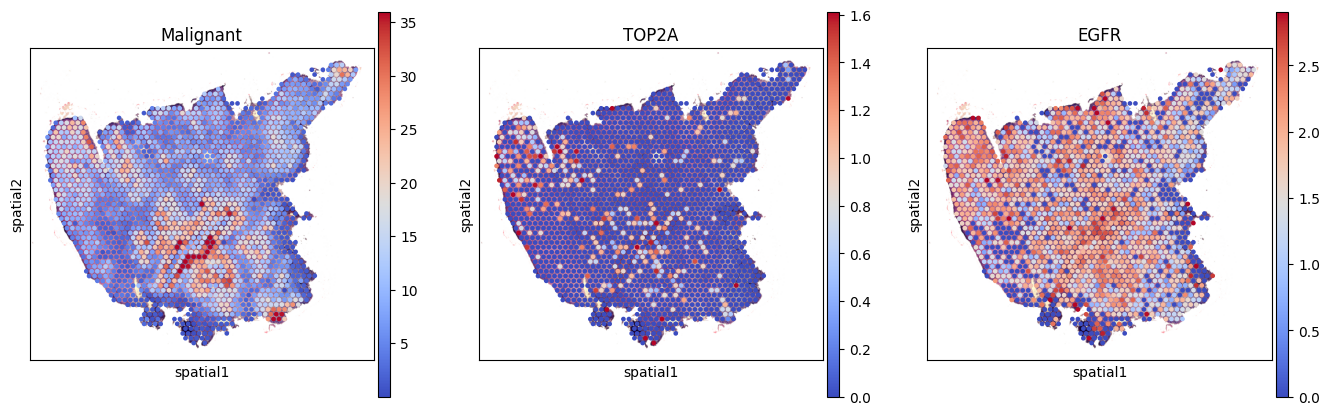

In [ ]:
selected_slide = '#UKF243_T_ST'
# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata, selected_slide)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(
        slide,
        cmap='coolwarm',
        # show first 8 cell types
        # color=['Malignant', 'EGFR', 'MAP2', 'TUBB3', 'SNAP25', 'GFAP', 'OLIG2', 'MBP', 'TMEM119', 'P2RY12', 'AIF1', 'CD14', 'MG/Mp', 'ILC/gdT', 'CD4_T', 'Oligodendrocytes', 'Treg', 'CD8', 'DC', 'Neutrophils'],
       color = ['Malignant', 'TOP2A', 'EGFR'],
        # color = ['MG/Mp', 'TMEM119', 'P2RY12', 'CD14', 'H1LA-DRA', 'CD4_T', 'Treg', 'CD8', 'Malignant', 'EGFR'],
       #  color = ['Malignant', 'MG/Mp', 'NSUN5', 'PILRB'],
        ncols=5,
        size=1.3,
        img_key='hires',
        # limit color scale at 99.2% quantile of cell abundance
       #  vmin = 3,
        vmax = 'p99.2',
       #  vmax = 6
)

In [ ]:
adata.var_names = adata.var_names.astype(str)
adata.var_names_make_unique()

In [ ]:
import gseapy as gp
gene_sets = gp.read_gmt('/home/jsw/BI/Database/HALLMARK_HYPOXIA.v2024.1.Hs.gmt')
hypoxia_genes = gene_sets['HALLMARK_HYPOXIA']
hypoxia_genes = [gene for gene in hypoxia_genes if gene in adata.var_names]
sc.tl.score_genes(adata, gene_list = hypoxia_genes, score_name = 'hypoxia_score')

In [ ]:
gene_sets = gp.read_gmt('/home/jsw/BI/Database/HALLMARK_GLYCOLYSIS.v2024.1.Hs.gmt')
glycolysis_genes= gene_sets['HALLMARK_GLYCOLYSIS']
glycolysis_genes = [gene for gene in glycolysis_genes if gene in adata.var_names]
sc.tl.score_genes(adata, gene_list = glycolysis_genes, score_name = 'glycolysis_score')

gene_sets = gp.read_gmt('/home/jsw/BI/Database/HALLMARK_OXIDATIVE_PHOSPHORYLATION.v2024.1.Hs.gmt')
olydative_phosphorylation_genes = gene_sets['HALLMARK_OXIDATIVE_PHOSPHORYLATION']
olydative_phosphorylation_genes = [gene for gene in olydative_phosphorylation_genes if gene in adata.var_names]
sc.tl.score_genes(adata, gene_list = olydative_phosphorylation_genes, score_name = 'oxidative_phosphorylation_score')

In [ ]:
gene_sets = gp.read_gmt('/home/jsw/BI/Database/GOBP_PHAGOCYTOSIS.v2024.1.Hs.gmt')
phagocytosis_genes= gene_sets['GOBP_PHAGOCYTOSIS']
phagocytosis_genes = [gene for gene in phagocytosis_genes if gene in adata.var_names]
sc.tl.score_genes(adata, gene_list = phagocytosis_genes, score_name = 'phagocytosis_score')

gene_sets = gp.read_gmt('/home/jsw/BI/Database/KEGG_FC_GAMMA_R_MEDIATED_PHAGOCYTOSIS.v2024.1.Hs.gmt')
fc_gamma_r_mediated_phagocytosis = gene_sets['KEGG_FC_GAMMA_R_MEDIATED_PHAGOCYTOSIS']
fc_gamma_r_mediated_phagocytosis = [gene for gene in fc_gamma_r_mediated_phagocytosis if gene in adata.var_names]
sc.tl.score_genes(adata, gene_list = fc_gamma_r_mediated_phagocytosis, score_name = 'fc_gamma_r_mediated_phagocytosis_score')

In [ ]:
tumor_genes = ['EGFR', 'PDGFRA', 'IDH1', 'VEGFA', 'TOP2A', 'TP53', 'PTEN', 'CDK4', 'KRAS']
tumor_genes = [gene for gene in tumor_genes if gene in adata.var_names]
sc.tl.score_genes(adata, gene_list = tumor_genes, score_name = 'tumor_score')

In [ ]:
tumor_genes = ['PDCD1', 'HAVCR2', 'LAG3', 'CD39', 'TOX', 'GZMB', 'CTLA4']
tumor_genes = [gene for gene in tumor_genes if gene in adata.var_names]
sc.tl.score_genes(adata, gene_list = tumor_genes, score_name = 'exhaustion_score')

In [ ]:
tumor_genes = ['A1BG',
 'ACTN4',
 'ADCK4',
 'AKT1S1',
 'AKT2',
 'ALDH16A1',
 'ALKBH6',
 'AP2S1',
 'APLP1',
 'APOC1',
 'APOC1P1',
 'APOC2',
 'ARHGEF1',
 'ASPDH',
 'ATF5',
 'ATP5SL',
 'AURKC',
 'AXL',
 'B3GNT8',
 'B9D2',
 'BAX',
 'BCAM',
 'BCAT2',
 'BCL2L12',
 'BCL3',
 'BLOC1S3',
 'BLVRB',
 'BRSK1',
 'C19orf12',
 'C19orf18',
 'C19orf40',
 'C19orf47',
 'C19orf48',
 'C19orf51',
 'C19orf54',
 'C19orf55',
 'C19orf63',
 'C19orf69',
 'C5AR1',
 'CAPN12',
 'CAPNS1',
 'CARD8',
 'CATSPERG',
 'CCDC114',
 'CCDC61',
 'CCDC8',
 'CCDC9',
 'CCDC97',
 'CCNE1',
 'CD33',
 'CD37',
 'CD3EAP',
 'CDC42EP5',
 'CEACAM1',
 'CEACAM21',
 'CEACAM22P',
 'CEACAM3',
 'CEACAM4',
 'CEBPA',
 'CEBPG',
 'CGB7',
 'CHMP2A',
 'CHST8',
 'CKM',
 'CLEC11A',
 'CLPTM1',
 'CNFN',
 'CNOT3',
 'CNTD2',
 'COX6B1',
 'COX6B2',
 'CTU1',
 'CYP2S1',
 'DEDD2',
 'DHDH',
 'DHX34',
 'DKKL1',
 'EGLN2',
 'EHD2',
 'EID2',
 'EID2B',
 'EIF3K',
 'EMP3',
 'EPS8L1',
 'ERCC1',
 'ERF',
 'ETHE1',
 'ETV2',
 'EXOC3L2',
 'FAM71E1',
 'FAM71E2',
 'FAM98C',
 'FBXO17',
 'FCAR',
 'FCGBP',
 'FCGRT',
 'FFAR2',
 'FIZ1',
 'FKRP',
 'FLJ26850',
 'FLT3LG',
 'FPR1',
 'FPR2',
 'FPR3',
 'FTL',
 'FUZ',
 'FXYD3',
 'FXYD5',
 'GEMIN7',
 'GGN',
 'GIPR',
 'GLTSCR1',
 'GMFG',
 'GPI',
 'GPR4',
 'GPR77',
 'GRWD1',
 'GSK3A',
 'GYS1',
 'HAMP',
 'HAUS5',
 'HCST',
 'HKR1',
 'HNRNPL',
 'HSD17B14',
 'HSPB6',
 'HSPBP1',
 'IGFL3',
 'IL11',
 'IL4I1',
 'IRF2BP1',
 'IRF3',
 'ISOC2',
 'ITPKC',
 'JOSD2',
 'KCNC3',
 'KCNK6',
 'KCNN4',
 'KDELR1',
 'KIRREL2',
 'KLK10',
 'KLK14',
 'KPTN',
 'LAIR1',
 'LENG9',
 'LGALS7',
 'LHB',
 'LIG1',
 'LILRA2',
 'LILRA3',
 'LILRA5',
 'LILRA6',
 'LILRB1',
 'LILRB2',
 'LILRB3',
 'LILRB4',
 'LOC100131691',
 'LOC147804',
 'MAG',
 'MAP4K1',
 'MBOAT7',
 'MEIS3',
 'MGC2752',
 'MIA',
 'MRPS12',
 'MYADM',
 'MYPOP',
 'MZF1',
 'NAPA',
 'NAPSB',
 'NAT14',
 'NCR1',
 'NDUFA3',
 'NFKBIB',
 'NFKBID',
 'NKG7',
 'NLRP12',
 'NLRP9',
 'NOSIP',
 'NTF4',
 'NUCB1',
 'NUDT19',
 'NUMBL',
 'NUP62',
 'OPA3',
 'OSCAR',
 'PAFAH1B3',
 'PAK4',
 'PDCD2L',
 'PDCD5',
 'PEPD',
 'PHLDB3',
 'PIH1D1',
 'PLAUR',
 'PLD3',
 'PLEKHA4',
 'PLEKHF1',
 'PLEKHG2',
 'PNKP',
 'POLD1',
 'POLR2I',
 'POP4',
 'PPP1R13L',
 'PPP1R15A',
 'PPP5C',
 'PRKD2',
 'PRMT1',
 'PRPF31',
 'PRR19',
 'PRR24',
 'PRRG2',
 'PSENEN',
 'PSMC4',
 'PSMD8',
 'PTGIR',
 'PVR',
 'PVRL2',
 'QPCTL',
 'RABAC1',
 'RASGRP4',
 'RBM42',
 'RCN3',
 'RDH13',
 'RELB',
 'RGS9BP',
 'RHPN2',
 'RINL',
 'RPL28',
 'RPS19',
 'RPS5',
 'RRAS',
 'RUVBL2',
 'SAE1',
 'SARS2',
 'SBSN',
 'SCN1B',
 'SDHAF1',
 'SELV',
 'SERTAD1',
 'SERTAD3',
 'SHKBP1',
 'SIGLEC10',
 'SIGLEC11',
 'SIGLEC14',
 'SIGLEC16',
 'SIGLEC5',
 'SIGLEC7',
 'SIGLEC9',
 'SIGLECP3',
 'SIPA1L3',
 'SIX5',
 'SLC1A5',
 'SLC27A5',
 'SLC7A9',
 'SNRPA',
 'SNRPD2',
 'SPIB',
 'SPRED3',
 'SRRM5',
 'SSC5D',
 'STRN4',
 'SULT2B1',
 'SUV420H2',
 'TBC1D17',
 'TBCB',
 'TEAD2',
 'TFPT',
 'TGFB1',
 'TMC4',
 'TMEM143',
 'TMEM147',
 'TMEM150B',
 'TMEM160',
 'TMEM190',
 'TMEM86B',
 'TOMM40',
 'TRAPPC2P1',
 'TRAPPC6A',
 'TRIM28',
 'TRPM4',
 'TSEN34',
 'TULP2',
 'TYROBP',
 'U2AF1L4',
 'U2AF2',
 'UBE2S',
 'UQCRFS1',
 'USP29',
 'VASP',
 'VRK3',
 'VSIG10L',
 'VSTM1',
 'WDR62',
 'WTIP',
 'XRCC1',
 'YIF1B',
 'ZBTB45',
 'ZFP28',
 'ZFP30',
 'ZFP36',
 'ZNF132',
 'ZNF155',
 'ZNF180',
 'ZNF181',
 'ZNF211',
 'ZNF226',
 'ZNF230',
 'ZNF234',
 'ZNF235',
 'ZNF256',
 'ZNF320',
 'ZNF345',
 'ZNF383',
 'ZNF415',
 'ZNF416',
 'ZNF432',
 'ZNF446',
 'ZNF45',
 'ZNF461',
 'ZNF468',
 'ZNF470',
 'ZNF473',
 'ZNF497',
 'ZNF524',
 'ZNF525',
 'ZNF526',
 'ZNF527',
 'ZNF528',
 'ZNF530',
 'ZNF541',
 'ZNF542',
 'ZNF544',
 'ZNF547',
 'ZNF548',
 'ZNF552',
 'ZNF565',
 'ZNF567',
 'ZNF568',
 'ZNF571',
 'ZNF574',
 'ZNF575',
 'ZNF576',
 'ZNF579',
 'ZNF580',
 'ZNF581',
 'ZNF582',
 'ZNF583',
 'ZNF584',
 'ZNF586',
 'ZNF587',
 'ZNF599',
 'ZNF600',
 'ZNF607',
 'ZNF613',
 'ZNF628',
 'ZNF701',
 'ZNF71',
 'ZNF761',
 'ZNF765',
 'ZNF766',
 'ZNF776',
 'ZNF784',
 'ZNF787',
 'ZNF790',
 'ZNF805',
 'ZNF808',
 'ZNF814',
 'ZNF83',
 'ZNF836',
 'ZNF837',
 'ZNF841',
 'ZNF880',
 'ZSCAN1',
 'ZSCAN22',
 'ZSCAN5A']
tumor_genes = [gene for gene in tumor_genes if gene in adata.var_names]
sc.tl.score_genes(adata, gene_list = tumor_genes, score_name = 'mdel_pgain_score')

In [ ]:
tumor_genes = ['ABCA13',
 'ABCB4',
 'ABCB5',
 'ABCB8',
 'ABCF2',
 'ABHD11',
 'ABP1',
 'ACN9',
 'ACTB',
 'ACTR3C',
 'ADCK2',
 'AEBP1',
 'AGBL3',
 'AGK',
 'AGR2',
 'AGR3',
 'AHR',
 'AIMP2',
 'AKR1B1',
 'AKR1D1',
 'ALKBH4',
 'ANKMY2',
 'AP1S1',
 'AP4M1',
 'AQP1',
 'ARF5',
 'ARL4A',
 'ARMC10',
 'ARPC1A',
 'ARPC1B',
 'ASL',
 'ASNS',
 'ATG9B',
 'ATP5J2',
 'ATP6V1F',
 'BBS9',
 'BCAP29',
 'BCL7B',
 'BET1',
 'BLVRA',
 'BPGM',
 'BRI3',
 'BUD31',
 'BZW2',
 'C1GALT1',
 'C7orf11',
 'C7orf23',
 'C7orf25',
 'C7orf26',
 'C7orf29',
 'C7orf30',
 'C7orf31',
 'C7orf42',
 'C7orf43',
 'C7orf44',
 'C7orf46',
 'C7orf49',
 'C7orf50',
 'C7orf53',
 'C7orf55',
 'C7orf57',
 'C7orf58',
 'C7orf59',
 'C7orf69',
 'C7orf70',
 'CALD1',
 'CALU',
 'CAPZA2',
 'CASP2',
 'CAV1',
 'CAV2',
 'CBX3',
 'CCDC126',
 'CCDC129',
 'CCDC146',
 'CCL26',
 'CCM2',
 'CCT6P1',
 'CD36',
 'CDCA7L',
 'CDK5',
 'CDK6',
 'CHCHD2',
 'CHCHD3',
 'CHPF2',
 'CHST12',
 'CLCN1',
 'CLDN12',
 'CLDN3',
 'CLDN4',
 'CLEC5A',
 'CLK2P',
 'CNPY1',
 'CNPY4',
 'COL1A2',
 'COPG2',
 'COPS6',
 'CPA1',
 'CPA2',
 'CPA4',
 'CPSF4',
 'CPVL',
 'CRCP',
 'CREB3L2',
 'CREB5',
 'CROT',
 'CUL1',
 'CUX1',
 'CYCS',
 'CYP3A5',
 'CYTH3',
 'DAGLB',
 'DBF4',
 'DBNL',
 'DDX56',
 'DENND2A',
 'DFNA5',
 'DLD',
 'DNAH11',
 'DNAJB6',
 'DNAJB9',
 'DNAJC2',
 'DNAJC30',
 'DPY19L1',
 'DPY19L2P1',
 'DTX2',
 'DUS4L',
 'EFCAB10',
 'EIF2AK1',
 'EIF3B',
 'EIF4H',
 'ELN',
 'EN2',
 'EPDR1',
 'EPHA1',
 'EPHB4',
 'EPHB6',
 'EPO',
 'EZH2',
 'FAM115C',
 'FAM126A',
 'FAM180A',
 'FAM185A',
 'FAM188B',
 'FAM200A',
 'FAM20C',
 'FAM3C',
 'FAM71F1',
 'FASTK',
 'FBXL13',
 'FDPSL2A',
 'FEZF1',
 'FGL2',
 'FIGNL1',
 'FIS1',
 'FKBP9',
 'FKBP9L',
 'FLJ35390',
 'FLJ40852',
 'FLNC',
 'FSCN1',
 'FSCN3',
 'FTSJ2',
 'FZD1',
 'GAL3ST4',
 'GARS',
 'GATAD1',
 'GBAS',
 'GBX1',
 'GCK',
 'GET4',
 'GGCT',
 'GIMAP2',
 'GIMAP4',
 'GLI3',
 'GNA12',
 'GNB2',
 'GNG11',
 'GPNMB',
 'GPR141',
 'GPR37',
 'GRB10',
 'GSTK1',
 'GTF2IRD2',
 'GTF2IRD2B',
 'GTPBP10',
 'GUSB',
 'HBP1',
 'HEATR2',
 'HERPUD2',
 'HGF',
 'HOXA1',
 'HOXA10',
 'HOXA11',
 'HOXA2',
 'HOXA3',
 'HOXA4',
 'HOXA5',
 'HOXA6',
 'HOXA7',
 'HOXA9',
 'HSPB1',
 'HUS1',
 'IFRD1',
 'IGF2BP3',
 'IGFBP3',
 'IKZF1',
 'IL6',
 'IMMP2L',
 'IMPDH1',
 'ING3',
 'INMT',
 'INSIG1',
 'IQUB',
 'IRF5',
 'ITGB8',
 'JAZF1',
 'KBTBD2',
 'KCP',
 'KDELR2',
 'KIAA0415',
 'KIAA0895',
 'KLRG2',
 'KPNA7',
 'KRBA1',
 'KRIT1',
 'LAMB1',
 'LAMB4',
 'LAT2',
 'LEP',
 'LFNG',
 'LIMK1',
 'LMOD2',
 'LOC100128822',
 'LOC100132707',
 'LOC100134713',
 'LOC154761',
 'LOC401397',
 'LOC407835',
 'LOC493754',
 'LOC541473',
 'LOC728743',
 'LOC729156',
 'LRCH4',
 'LRGUK',
 'LRRC17',
 'LRRC61',
 'LRWD1',
 'LSM5',
 'LUZP6',
 'MACC1',
 'MAD1L1',
 'MAFK',
 'MCM7',
 'MDFIC',
 'MDH2',
 'MEOX2',
 'MEST',
 'MET',
 'MGC16142',
 'MICALL2',
 'MIOS',
 'MOSPD3',
 'MRPL32',
 'MRPS17',
 'MRPS24',
 'MRPS33',
 'MTERF',
 'MUC12',
 'MYO1G',
 'NAA38',
 'NAMPT',
 'NCAPG2',
 'NCF1',
 'NCF1B',
 'NCF1C',
 'NDUFA4',
 'NDUFA5',
 'NDUFB2',
 'NFE2L3',
 'NOD1',
 'NOM1',
 'NOS3',
 'NPC1L1',
 'NPTX2',
 'NPY',
 'NSUN5',
 'NSUN5P1',
 'NSUN5P2',
 'NT5C3',
 'NUB1',
 'NUDT1',
 'NUP205',
 'NUPL2',
 'OGDH',
 'OPN1SW',
 'OR2A9P',
 'OR2AE1',
 'ORAI2',
 'OSBPL3',
 'PARP12',
 'PAXIP1',
 'PCOLCE',
 'PDAP1',
 'PDE1C',
 'PDGFA',
 'PDIA4',
 'PEX1',
 'PGAM2',
 'PHTF2',
 'PIK3CG',
 'PILRA',
 'PILRB',
 'PION',
 'PKD1L1',
 'PLOD3',
 'PMPCB',
 'PMS2CL',
 'PMS2L2',
 'PODXL',
 'POLD2',
 'POLM',
 'POLR2J',
 'POLR2J4',
 'POM121C',
 'POMZP3',
 'POP7',
 'POR',
 'PPIA',
 'PRKRIP1',
 'PRR15',
 'PSMA2',
 'PSMC2',
 'PSMG3',
 'PSPH',
 'PTCD1',
 'PTN',
 'PTPN12',
 'PUS7',
 'RAB19',
 'RABGEF1',
 'RABL5',
 'RAC1',
 'RADIL',
 'RAMP3',
 'RARRES2',
 'RBM28',
 'RFC2',
 'RHBDD2',
 'RINT1',
 'RNF133',
 'RNF148',
 'RP9',
 'RP9P',
 'RPA3',
 'RPS2P32',
 'RSPH10B2',
 'SAMD9',
 'SAMD9L',
 'SBDS',
 'SBDSP1',
 'SCIN',
 'SDK1',
 'SEC61G',
 'SEMA3A',
 'SEMA3E',
 'SEPT7P2',
 'SERPINE1',
 'SFRP4',
 'SGCE',
 'SHFM1',
 'SKAP2',
 'SLC12A9',
 'SLC13A4',
 'SLC25A13',
 'SLC26A4',
 'SLC35B4',
 'SLC37A3',
 'SLC4A2',
 'SMO',
 'SMURF1',
 'SNX10',
 'SNX8',
 'SP8',
 'SPDYE2',
 'SPDYE6',
 'SPDYE8P',
 'SRCRB4D',
 'SRRT',
 'SSBP1',
 'STAG3L1',
 'STAG3L2',
 'STAG3L4',
 'STARD3NL',
 'STEAP1',
 'STK17A',
 'STYXL1',
 'SUMF2',
 'SUN1',
 'SVOPL',
 'SYPL1',
 'TAF6',
 'TBL2',
 'TBRG4',
 'TBXAS1',
 'TES',
 'TFEC',
 'TFPI2',
 'TFR2',
 'TMED4',
 'TMEM120A',
 'TMEM140',
 'TMEM168',
 'TMEM176A',
 'TMEM176B',
 'TMEM209',
 'TMEM60',
 'TMUB1',
 'TOMM7',
 'TP53TG1',
 'TPK1',
 'TPST1',
 'TRIM4',
 'TRIM56',
 'TRIP6',
 'TRPV6',
 'TSPAN12',
 'TSPAN13',
 'TTC26',
 'TTYH3',
 'TWIST1',
 'TWISTNB',
 'TXNDC3',
 'TYW1',
 'TYW1B',
 'UBE2D4',
 'UBE3C',
 'UFSP1',
 'UPK3BL',
 'UPP1',
 'USP42',
 'VGF',
 'VKORC1L1',
 'VOPP1',
 'VWDE',
 'WBSCR16',
 'WBSCR22',
 'WBSCR27',
 'WBSCR28',
 'WIPF3',
 'WNT16',
 'XRCC2',
 'YKT6',
 'ZC3HAV1L',
 'ZC3HC1',
 'ZDHHC4',
 'ZFAND2A',
 'ZKSCAN5',
 'ZNF12',
 'ZNF394',
 'ZNF655',
 'ZNF746',
 'ZNF789',
 'ZNF815',
 'ZNF853',
 'ZNHIT1',
 'ZNRF2',
 'ZP3',
 'ZYX']
tumor_genes = [gene for gene in tumor_genes if gene in adata.var_names]
sc.tl.score_genes(adata, gene_list = tumor_genes, score_name = 'gain_score')

In [ ]:
tumor_genes = ['ABCC2',
 'ABI1',
 'ABLIM1',
 'ACADSB',
 'ACBD5',
 'ACBD7',
 'ACTR1A',
 'ADARB2',
 'ADD3',
 'ADO',
 'ADRA2A',
 'AFAP1L2',
 'AGAP4',
 'AKR1C1',
 'AKR1C2',
 'AKR1C3',
 'AKR1C4',
 'ALDH18A1',
 'ANK3',
 'ANKRD16',
 'ANKRD2',
 'ANKRD26',
 'ANXA7',
 'ANXA8',
 'ANXA8L2',
 'AP3M1',
 'ARHGAP12',
 'ARHGAP19',
 'ARHGAP21',
 'ARHGAP22',
 'ARL3',
 'ARL5B',
 'ARMC3',
 'ARMC4',
 'ASAH2B',
 'ASB13',
 'ASCC1',
 'ATAD1',
 'ATE1',
 'ATOH7',
 'ATP5C1',
 'ATRNL1',
 'AVPI1',
 'BAG3',
 'BCCIP',
 'BEND7',
 'BICC1',
 'BLOC1S2',
 'BMI1',
 'BMPR1A',
 'BMS1',
 'BMS1P5',
 'BTAF1',
 'BTRC',
 'BUB3',
 'C10orf116',
 'C10orf118',
 'C10orf12',
 'C10orf120',
 'C10orf131',
 'C10orf137',
 'C10orf2',
 'C10orf25',
 'C10orf26',
 'C10orf28',
 'C10orf32',
 'C10orf46',
 'C10orf53',
 'C10orf58',
 'C10orf68',
 'C10orf76',
 'C10orf88',
 'C1QL3',
 'CALHM1',
 'CALML3',
 'CALY',
 'CAMK1D',
 'CAMK2G',
 'CASC2',
 'CCAR1',
 'CCDC6',
 'CCNJ',
 'CCNY',
 'CDC123',
 'CDHR1',
 'CDNF',
 'CELF2',
 'CHST15',
 'CHST3',
 'CHUK',
 'CISD1',
 'CNNM1',
 'CNNM2',
 'COX15',
 'CPEB3',
 'CRTAC1',
 'CSGALNACT2',
 'CSTF2T',
 'CTBP2',
 'CTNNA3',
 'CUEDC2',
 'CUL2',
 'CUTC',
 'CWF19L1',
 'CYP17A1',
 'CYP2E1',
 'DCLRE1A',
 'DDIT4',
 'DDX21',
 'DDX50',
 'DHTKD1',
 'DIP2C',
 'DLG5',
 'DNAJB12',
 'DNAJC12',
 'DNAJC9',
 'DNMBP',
 'DOCK1',
 'DPYSL4',
 'DRGX',
 'ECD',
 'EIF3A',
 'EIF4EBP2',
 'EMX2OS',
 'EPC1',
 'ERCC6',
 'EXOC6',
 'FAM107B',
 'FAM13C',
 'FAM149B1',
 'FAM160B1',
 'FAM171A1',
 'FAM175B',
 'FAM178A',
 'FAM188A',
 'FAM190B',
 'FAM21A',
 'FAM21B',
 'FAM21C',
 'FAM22A',
 'FAM22D',
 'FAM24B',
 'FAM35A',
 'FAM35B',
 'FAM35B2',
 'FAM45A',
 'FAM53B',
 'FBXO18',
 'FBXW4',
 'FGF8',
 'FGFBP3',
 'FLJ37201',
 'FRAT1',
 'FRAT2',
 'FRMD4A',
 'FRMPD2',
 'GAD2',
 'GBF1',
 'GDF10',
 'GDI2',
 'GFRA1',
 'GHITM',
 'GLUD1',
 'GOLGA7B',
 'GOT1',
 'GPAM',
 'GPR123',
 'GPR158',
 'GPR26',
 'GPRIN2',
 'GRID1',
 'GSTO2',
 'GTPBP4',
 'H2AFY2',
 'HECTD2',
 'HERC4',
 'HIF1AN',
 'HNRNPA3P1',
 'HNRNPH3',
 'HPS6',
 'HPSE2',
 'HSD17B7P2',
 'HSPA12A',
 'HSPA14',
 'IDI1',
 'IDI2',
 'IFIT2',
 'IFIT5',
 'IKZF5',
 'INA',
 'INPP5A',
 'INPP5F',
 'IPMK',
 'JAKMIP3',
 'JMJD1C',
 'KCNIP2',
 'KCNK18',
 'KCNMA1',
 'KIAA0913',
 'KIAA1279',
 'KIAA1462',
 'KIF11',
 'KIF20B',
 'KIF5B',
 'KIN',
 'KLF6',
 'KNDC1',
 'LARP4B',
 'LCOR',
 'LDB1',
 'LDB3',
 'LOC100128292',
 'LOC100129055',
 'LOC100188947',
 'LOC143188',
 'LOC219347',
 'LOC282997',
 'LOC283070',
 'LOC387647',
 'LOC399744',
 'LOC441666',
 'LOC619207',
 'LOC642826',
 'LOC650623',
 'LOC728190',
 'LOC728640',
 'LOC728643',
 'LOC729020',
 'LOC731789',
 'LOC84856',
 'LOC84989',
 'LRIT2',
 'LRRC20',
 'LRRC27',
 'LRRTM3',
 'LZTS2',
 'MAPK8',
 'MASTL',
 'MBL1P',
 'MEIG1',
 'METTL10',
 'MGEA5',
 'MINPP1',
 'MKX',
 'MMS19',
 'MORN4',
 'MPP7',
 'MRPL43',
 'MRPS16',
 'MSRB2',
 'MTPAP',
 'MXI1',
 'NANOS1',
 'NCOA4',
 'NDST2',
 'NEBL',
 'NET1',
 'NEURL',
 'NEUROG3',
 'NHLRC2',
 'NKX1-2',
 'NMT2',
 'NOC3L',
 'NOLC1',
 'NPFFR1',
 'NRG3',
 'NSMCE4A',
 'NSUN6',
 'NT5C2',
 'NUDT9P1',
 'OAT',
 'OPALIN',
 'OPTN',
 'OR13A1',
 'OTUD1',
 'PANK1',
 'PARD3',
 'PARG',
 'PBLD',
 'PCDH15',
 'PCGF5',
 'PCGF6',
 'PDCD11',
 'PDCD4',
 'PDE6C',
 'PDSS1',
 'PDZD7',
 'PDZD8',
 'PFKP',
 'PGBD3',
 'PHYHIPL',
 'PI4K2A',
 'PIP4K2A',
 'PITRM1',
 'PITX3',
 'PLEKHA1',
 'POLL',
 'POLR3A',
 'PPA1',
 'PPAPDC1A',
 'PPIF',
 'PPP1R3C',
 'PPP2R2D',
 'PPP3CB',
 'PPRC1',
 'PPYR1',
 'PRAP1',
 'PRKCQ',
 'PRKG1',
 'PRLHR',
 'PRPF18',
 'PRTFDC1',
 'PSD',
 'PSTK',
 'PTEN',
 'PTER',
 'PTF1A',
 'PTPRE',
 'PWWP2B',
 'RAB11FIP2',
 'RAB18',
 'RASSF4',
 'RBM17',
 'RBP3',
 'RET',
 'RGR',
 'RPP30',
 'RPS24',
 'RRP12',
 'RUFY2',
 'SAMD8',
 'SAR1A',
 'SCD',
 'SEC23IP',
 'SEC24C',
 'SEC31B',
 'SEC61A2',
 'SEMA4G',
 'SEPHS1',
 'SEPT7L',
 'SFMBT2',
 'SFTPA2',
 'SFTPD',
 'SFXN2',
 'SFXN4',
 'SGMS1',
 'SGPL1',
 'SH3PXD2A',
 'SHOC2',
 'SIRT1',
 'SLC16A9',
 'SLC25A28',
 'SLIT1',
 'SLK',
 'SMC3',
 'SNCG',
 'SORBS1',
 'SORCS1',
 'SORCS3',
 'SPOCK2',
 'SPRN',
 'ST8SIA6',
 'STAM',
 'STAMBPL1',
 'STK32C',
 'STOX1',
 'SUFU',
 'SUPV3L1',
 'SYCE1',
 'SYNPO2L',
 'SYT15',
 'TACC2',
 'TAF3',
 'TAF5',
 'TBC1D12',
 'TCERG1L',
 'TCF7L2',
 'TET1',
 'TFAM',
 'THNSL1',
 'TIAL1',
 'TLX1',
 'TLX1NB',
 'TM9SF3',
 'TMEM180',
 'TMEM72',
 'TNKS2',
 'TRIM8',
 'TRUB1',
 'TSPAN14',
 'TSPAN15',
 'TUBB8',
 'TUBGCP2',
 'TYSND1',
 'UBE2D1',
 'UPF2',
 'UROS',
 'USP54',
 'VAX1',
 'VCL',
 'VDAC2',
 'VPS26A',
 'VTI1A',
 'VWA2',
 'WAC',
 'WAPAL',
 'WDR11',
 'WDR37',
 'WNT8B',
 'XPNPEP1',
 'YME1L1',
 'ZCCHC24',
 'ZEB1',
 'ZFYVE27',
 'ZMIZ1',
 'ZMYND11',
 'ZMYND17',
 'ZNF22',
 'ZNF239',
 'ZNF248',
 'ZNF25',
 'ZNF32',
 'ZNF33A',
 'ZNF33B',
 'ZNF365',
 'ZNF37A',
 'ZNF438',
 'ZNF485',
 'ZNF488',
 'ZNF518A',
 'ZRANB1']
tumor_genes = [gene for gene in tumor_genes if gene in adata.var_names]
sc.tl.score_genes(adata, gene_list = tumor_genes, score_name = 'del_score')

In [ ]:
tumor_genes = []
tumor_genes = [gene for gene in tumor_genes if gene in adata.var_names]
sc.tl.score_genes(adata, gene_list = tumor_genes, score_name = 'gc_marker')

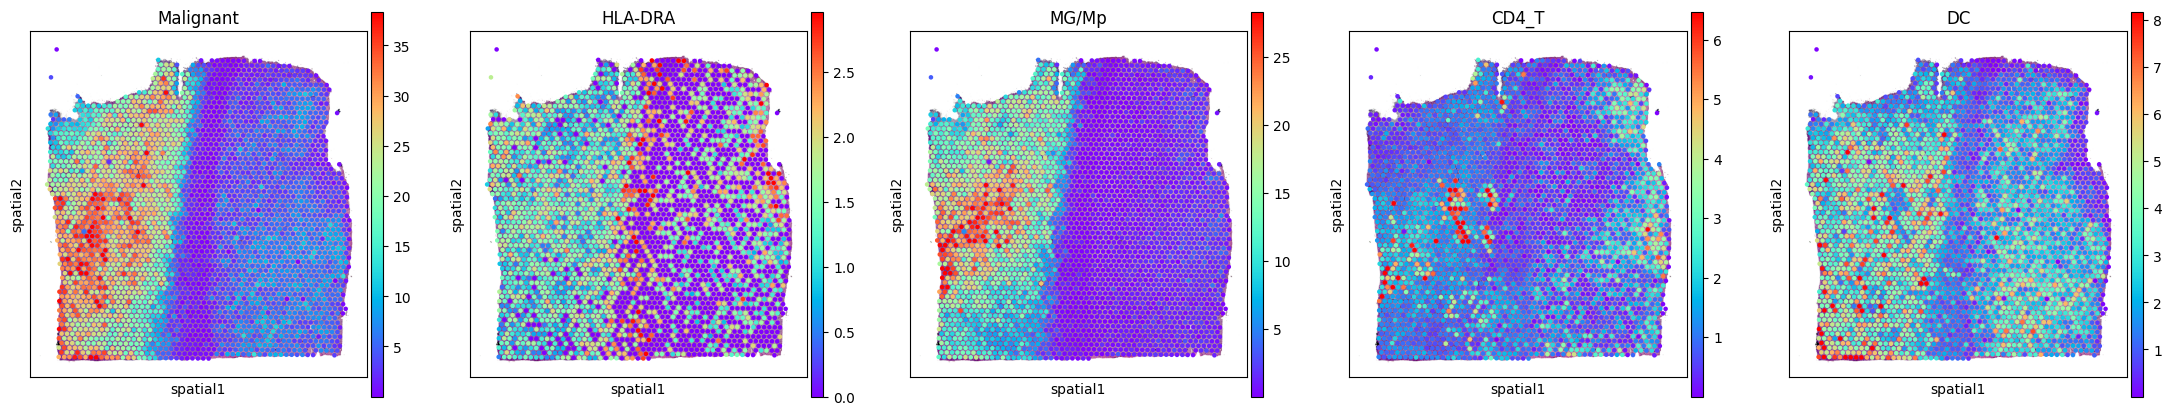

In [820]:
selected_slide = '#UKF269_T_ST'
# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata, selected_slide)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(
        slide,
        cmap='rainbow',
        # show first 8 cell types
        # color=['Malignant','oxidative_phosphorylation_score', 'glycolysis_score', 'hypoxia_score', 'MG/Mp', 'ILC/gdT', 'CD4_T', 'Oligodendrocytes',
        #        'Treg', 'CD8', 'DC', 'Neutrophils'],
        color = ['Malignant', 'HLA-DRA', 'MG/Mp', 'CD4_T', 'DC'],
        # color=['Malignant', 'EGFR', 'hypoxia_score', 'glycolysis_score'],
        # color = ['mdel_pgain_score', 'gain_score', 'Malignant', 'MG/Mp', 'hypoxia_score',],
    #    color = ['Malignant', 'MG/Mp', 'hypoxia_score',],
        # color = ['MG/Mp', 'TMEM119', 'P2RY12', 'CD14', 'H1LA-DRA', 'CD4_T', 'Treg', 'CD8', 'Malignant', 'EGFR'],
       #  color = ['Malignant', 'MG/Mp', 'NSUN5', 'PILRB'],
        ncols=5,
        size=1.3,
        img_key='hires',
        # limit color scale at 99.2% quantile of cell abundance
       #  vmin = 3,
        vmax = 'p99.2',
        # vmax = 0.3
)

In [ ]:
selected_slide = '#UKF334_T_ST'
# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata, selected_slide)

element_1 = 'CD4_T'
element_2 = 'hypoxia_score'
element_3 = 'CD8'



df1 = slide.obs[element_1].copy()
df2 = slide.obs[element_2].copy()
df3 = slide.obs[element_3].copy()

Pearson Correlation Coefficient: 0.444, p-value: 1.485e-198
Spearman Correlation Coefficient: 0.407, p-value: 6.218e-164
There is a statistically significant correlation (Pearson) between hypoxia_score and CD4_T
There is a statistically significant correlation (Spearman) between hypoxia_score and CD4_T


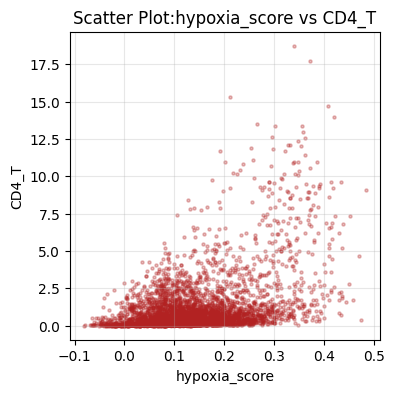

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# 데이터 병합
df = pd.concat([df1, df2, df3], axis=1)

pearson_corr, pearson_pval = pearsonr(df[element_1], df[element_2])

# 산포도 그리기
plt.figure(figsize=(4, 4))
# sns.regplot(x=element_1, y=element_2, data=df, ci=None, scatter_kws={'alpha': 0.5, 's': 10}, line_kws={'color': 'firebrick'}, color = 'gray')
plt.scatter(df[element_1], df[element_2], alpha=0.3, c='firebrick', s = 5)
plt.title(f'Scatter Plot:{element_1} vs {element_2}')
plt.xlabel(element_1)
plt.ylabel(element_2)
plt.grid(alpha=0.3)

# 상관계수 계산 (Pearson 및 Spearman)
pearson_corr, pearson_pval = pearsonr(df[element_1], df[element_2])
spearman_corr, spearman_pval = spearmanr(df[element_1], df[element_2])

# 결과 출력
print("Pearson Correlation Coefficient: {:.3f}, p-value: {:.3e}".format(pearson_corr, pearson_pval))
print("Spearman Correlation Coefficient: {:.3f}, p-value: {:.3e}".format(spearman_corr, spearman_pval))

# 상관계수 해석
if pearson_pval < 0.05:
    print(f"There is a statistically significant correlation (Pearson) between {element_1} and {element_2}")
else:
    print(f"No statistically significant correlation (Pearson) between {element_1} and {element_2}")

if spearman_pval < 0.05:
    print(f"There is a statistically significant correlation (Spearman) between {element_1} and {element_2}")
else:
    print(f"No statistically significant correlation (Spearman) between {element_1} and {element_2}")

plt.show()


Pearson Correlation Coefficient: 0.322, p-value: 2.757e-100
Spearman Correlation Coefficient: 0.647, p-value: 0.000e+00
There is a statistically significant correlation (Pearson) between CD4_T and CD8
There is a statistically significant correlation (Spearman) between CD4_T and CD8


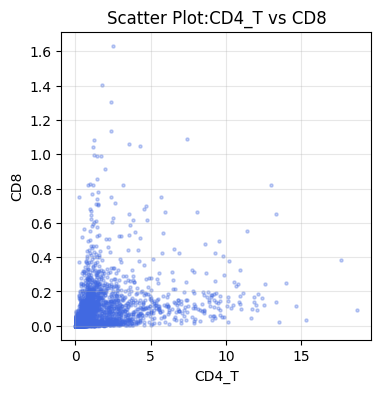

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# 데이터 병합
df = pd.concat([df1, df2, df3], axis=1)

pearson_corr, pearson_pval = pearsonr(df[element_1], df[element_3])

# 산포도 그리기
plt.figure(figsize=(4, 4))
# sns.regplot(x=element_1, y=element_3, data=df, ci=None, scatter_kws={'alpha': 0.5, 's': 10}, line_kws={'color': 'firebrick'}, color = 'gray')
plt.scatter(df[element_1], df[element_3], alpha=0.3, c='royalblue', s = 5)

plt.title(f'Scatter Plot:{element_1} vs {element_3}')
plt.xlabel(element_1)
plt.ylabel(element_3)
plt.grid(alpha=0.3)

# 상관계수 계산 (Pearson 및 Spearman)
pearson_corr, pearson_pval = pearsonr(df[element_1], df[element_3])
spearman_corr, spearman_pval = spearmanr(df[element_1], df[element_3])

# 결과 출력
print("Pearson Correlation Coefficient: {:.3f}, p-value: {:.3e}".format(pearson_corr, pearson_pval))
print("Spearman Correlation Coefficient: {:.3f}, p-value: {:.3e}".format(spearman_corr, spearman_pval))

# 상관계수 해석
if pearson_pval < 0.05:
    print(f"There is a statistically significant correlation (Pearson) between {element_1} and {element_3}")
else:
    print(f"No statistically significant correlation (Pearson) between {element_1} and {element_3}")

if spearman_pval < 0.05:
    print(f"There is a statistically significant correlation (Spearman) between {element_1} and {element_3}")
else:
    print(f"No statistically significant correlation (Spearman) between {element_1} and {element_3}")

plt.show()


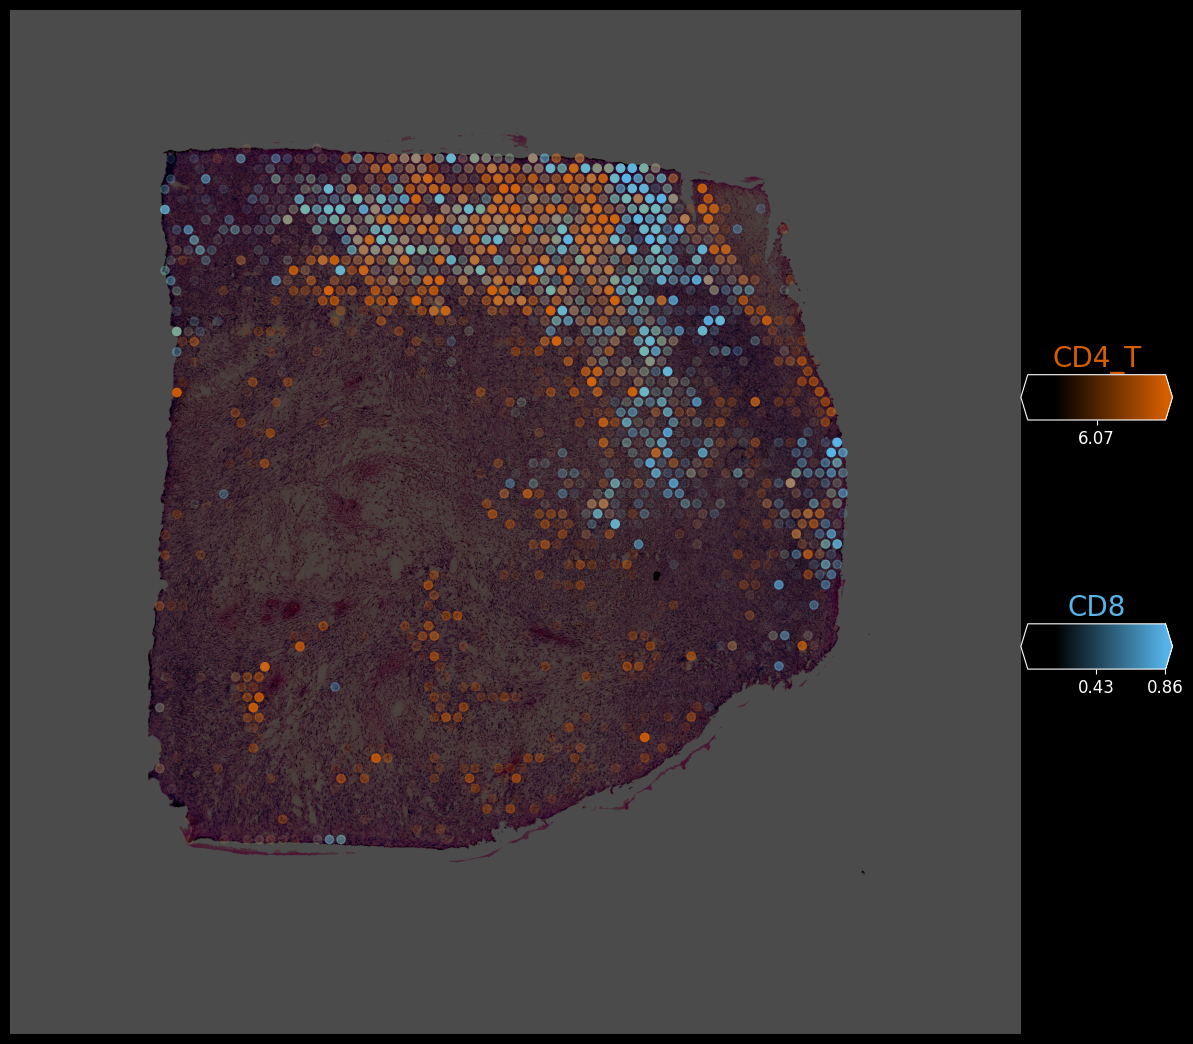

In [ ]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

selected_slide = '#UKF313_T_ST'

# select up to 6 clusters
clust_labels = ['CD4_T', 'CD8']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

slide = select_slide(adata, selected_slide)

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='dark_background',
        # limit color scale at 99.2% quantile of cell abundance
        # max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right',
        img_alpha = 0.3,
        reorder_cmap = range(1, 7)
    )
plt.show()


---
# cell-type specific expression of every gene in the spatial data

In [ ]:
# Compute expected expression per cell type
expected_dict = mod.module.model.compute_expected_per_cell_type(
    mod.samples["post_sample_q05"], mod.adata_manager
)

# Add to anndata layers
for i, n in enumerate(mod.factor_names_):
    adata.layers[n] = expected_dict['mu'][i]

# Save anndata object with results
adata_file = 'sp_2.h5ad'
adata.write(adata_file)
adata_file



'sp_2.h5ad'

In [ ]:
adata.obs['CD4_T']

spot_id
#UKF260_T_ST_AAACAATCTACTAGCA-1    0.032883
#UKF260_T_ST_AAACAGAGCGACTCCT-1    4.534727
#UKF260_T_ST_AAACAGCTTTCAGAAG-1    0.124040
#UKF260_T_ST_AAACAGGGTCTATATT-1    0.171009
#UKF260_T_ST_AAACATGGTGAGAGGA-1    2.216866
                                     ...   
#UKF241_C_ST_TTGTGTTTCCCGAAAG-1    0.008175
#UKF241_C_ST_TTGTTAGCAAATTCGA-1    0.004456
#UKF241_C_ST_TTGTTCAGTGTGCTAC-1    0.037133
#UKF241_C_ST_TTGTTGTGTGTCAAGA-1    0.011325
#UKF241_C_ST_TTGTTTCACATCCAGG-1    0.004396
Name: CD4_T, Length: 33094, dtype: float64

In [ ]:
adata.var['SYMBOL'] = adata.var_names

In [803]:
def plot_genes_per_cell_type(slide, genes, ctypes):
    n_genes = len(genes)
    n_ctypes = len(ctypes)
    fig, axs = plt.subplots(
        nrows=n_genes, ncols=n_ctypes + 1, figsize=(4.5 * (n_ctypes + 1) + 2, 5 * n_genes + 1), squeeze=False
    )
    # axs = axs.reshape((n_genes, n_ctypes+1))

    # plots of every gene
    for j in range(n_genes):
        # limit color scale at 99.2% quantile of gene expression (computed across cell types)
        quantile_across_ct = np.array(
            [
                np.quantile(slide.layers[n][:, slide.var["SYMBOL"] == genes[j]].toarray(), 0.992)
                for n in slide.uns["mod"]["factor_names"]
            ]
        )
        quantile_across_ct = np.partition(quantile_across_ct.flatten(), -2)[-2]
        sc.pl.spatial(
            slide,
            cmap="rainbow",
            color=genes[j],
            # layer=ctypes[i],
            gene_symbols="SYMBOL",
            ncols=4,
            size=1.3,
            img_key="hires",
            # limit color scale at 99.2% quantile of gene expression
            vmin=0,
            vmax="p99.2",
            ax=axs[j, 0],
            show=False,
        )

        # plots of every cell type
        for i in range(n_ctypes):
            sc.pl.spatial(
                slide,
                cmap="rainbow",
                color=genes[j],
                layer=ctypes[i],
                gene_symbols="SYMBOL",
                ncols=4,
                size=1.3,
                img_key="hires",
                # limit color scale at 99.2% quantile of gene expression
                vmin=0,
                # vmax=quantile_across_ct,
                
                ax=axs[j, i + 1],
                show=False,
            )
            axs[j, i + 1].set_title(f"{genes[j]} {ctypes[i]}")

    return fig, axs

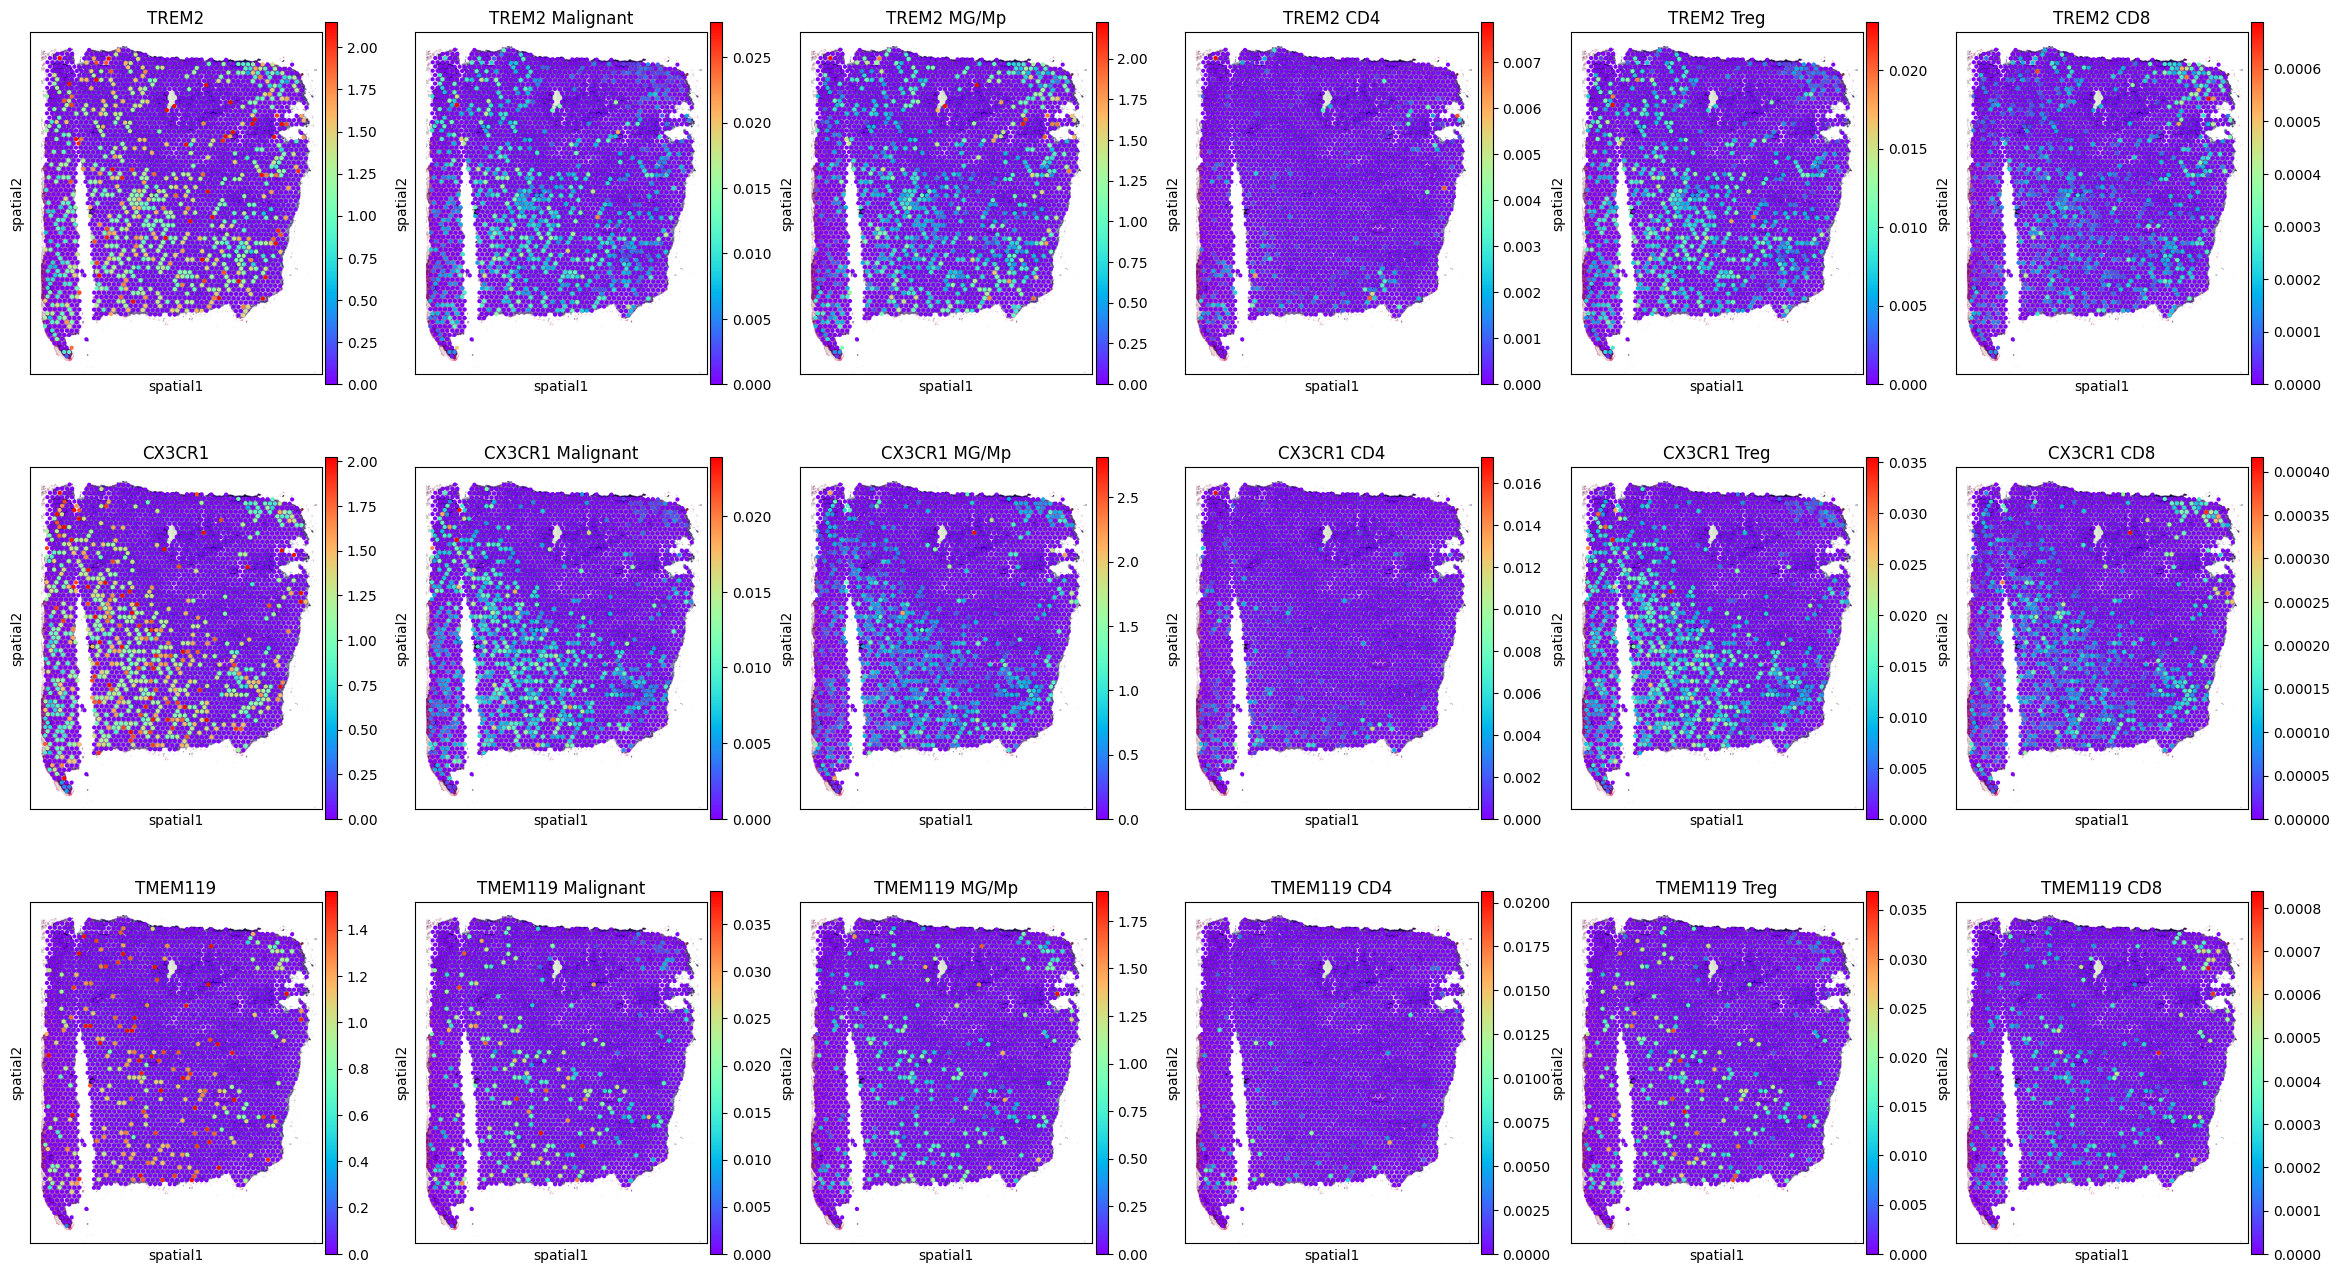

In [806]:
# list cell types and genes for plotting
ctypes = ['Malignant', 'MG/Mp', 'CD4', 'Treg', 'CD8']
genes = ['TREM2', 'CX3CR1', 'TMEM119']

with mpl.rc_context({'axes.facecolor':  'black'}):
    # select one slide
    slide = select_slide(adata, '#UKF260_T_ST')

    # from tutorial_utils import plot_genes_per_cell_type
    plot_genes_per_cell_type(slide, genes, ctypes);